# Задание 1

## Подготовка набора данных

Для загрузки данных используем `scikit-learn`. Далее выполняем нормировку данных и применяем one-hot encoding к целевой колонке. Для обучения выделяем 90% данных, а для тестирования — 10%.

In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", version=1)

X = mnist.data.astype(np.float32).to_numpy() / 255.0
y = np.eye(10)[mnist.target.astype(int)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Проверка реализованных функций

In [1]:
import matplotlib.pyplot as plt
from mytorch.nn import Module, Linear, Sequential, ReLU, GELU, Swish, Softplus, MSELoss
from mytorch.optim import SGD, Optimizer

from tqdm import tqdm

In [14]:
import torch


def as_numpy(tensor):
    return tensor.detach().numpy()


def as_tensor(numpy_array):
    return torch.tensor(numpy_array).float()


def generate(n):
    return torch.randn(n, requires_grad=True)


def check_activation(torch_activation, my_activation):
    x = generate(10)
    grad = generate(10)

    expected_y = torch_activation(x)
    expected_y.backward(grad)

    actual_y = my_activation(as_numpy(x))

    assert torch.allclose(expected_y, as_tensor(actual_y))
    assert torch.allclose(x.grad, as_tensor(my_activation.backward(as_numpy(grad))))
    if hasattr(torch_activation, "beta"):
        assert torch.allclose(
            torch_activation.beta.grad, as_tensor(my_activation.beta.grad)
        )

### Проверка реализации RELU

In [16]:
check_activation(torch.nn.ReLU(), ReLU())
print("ReLU совпадает с torch.nn.ReLU")

ReLU совпадает с torch.nn.ReLU


### Проверка реализации GELU

In [17]:
check_activation(torch.nn.GELU(), GELU())
print("GELU совпадает с torch.nn.GELU")

GELU совпадает с torch.nn.GELU


### Проверка реализации Swish

In [20]:
class AutogradableSwish(torch.nn.Module):
    def __init__(self, beta_init=1.0):
        super(AutogradableSwish, self).__init__()
        self.beta = torch.nn.Parameter(torch.tensor(beta_init))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)


check_activation(AutogradableSwish(), Swish())
print("Swish совпадает с AutogradableSwish")

Swish совпадает с AutogradableSwish


### Проверка реализации Softplus

In [21]:
class AutogradableSoftplus(torch.nn.Module):
    def __init__(self, beta_init=1.0):
        super(AutogradableSoftplus, self).__init__()
        self.beta = torch.nn.Parameter(torch.tensor(beta_init))

    def forward(self, x):
        return 1 / self.beta * torch.log(1 + torch.exp(self.beta * x))


check_activation(AutogradableSoftplus(), Softplus())
print("Softplus совпадает с AutogradableSoftplus")

Softplus совпадает с AutogradableSoftplus


## Обучение моделей

In [3]:
class Net(Module):
    def __init__(self, module: Module, criterion: Module):
        super().__init__()
        self.module = module
        self.criterion = criterion

    def forward(self, x):
        return self.module(x)

    def loss(self, *args):
        return self.criterion(*args)

    def backward(self):
        grad = self.criterion.backward()
        return self.module.backward(grad)

    def parameters(self):
        return self.module.parameters()

In [4]:
np.random.seed(1)


def train_loop(
    net: Net,
    optimizer: Optimizer,
    X_train: np.ndarray,
    y_train: np.ndarray,
    num_epochs: int = 200,
):
    accuracy = []

    for _ in tqdm(range(num_epochs)):
        y_pred = net.forward(X_train)
        net.loss(y_pred, y_train)

        y_pred_labels = np.argmax(y_pred, axis=1)
        y_train_labels = np.argmax(y_train, axis=1)
        accuracy.append(np.mean(y_pred_labels == y_train_labels))

        net.backward()

        optimizer.step()
        optimizer.zero_grad()

    return accuracy

In [5]:
def test_activation(Activation):
    net = Net(
        Sequential(
            Linear(in_features=784, out_features=800),
            Activation(),
            Linear(in_features=800, out_features=400),
            Activation(),
            Linear(in_features=400, out_features=10),
        ),
        MSELoss(),
    )
    optimizer = SGD(net.parameters(), lr=5e-3)
    accuracy = train_loop(net, optimizer, X_train, y_train, num_epochs=500)
    plt.plot(accuracy, label=Activation.__name__)

100%|██████████| 500/500 [38:52<00:00,  4.67s/it]  


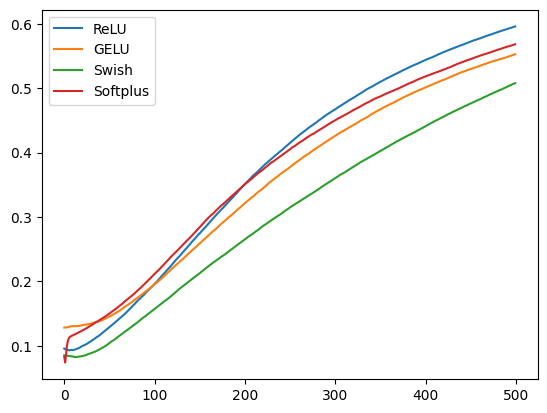

In [6]:
test_activation(ReLU)
test_activation(GELU)
test_activation(Swish)
test_activation(Softplus)


plt.legend()
plt.show()

## Вывод

1. Графики показывают, что данной модели удалось добиться точности примерно 60% за 500 эпох.
2. Графики зависимости точности от эпохи стабильно идут вверх. Можно предположить, что при большем числе эпох удалось бы лучше обучить модель.
3. Уже полученных данных достаточно, чтобы увидеть, что на наборе данных MNIST функция активации `ReLU` показала себя лучше всего.
4. Наименьшей точности удалось добиться с использованием `Swish`.